# Bosonic Dimer

In [ ]:
using Pkg; 
Pkg.activate()
#Pkg.add("FFTW")
#Pkg.add("Interpolations")

  Activating project at `~/.julia/environments/v1.10`
   Resolving package versions...
   Installed FFTW ───── v1.9.0
   Installed FFTW_jll ─ v3.3.11+0
    Updating `~/.julia/environments/v1.10/Project.toml`
  [7a1cc6ca] + FFTW v1.9.0
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [7a1cc6ca] + FFTW v1.9.0
  [f5851436] + FFTW_jll v3.3.11+0
Precompiling packages...
   1072.6 ms  ✓ FFTW_jll
   4366.5 ms  ✓ FFTW
   1235.2 ms  ✓ Polynomials → PolynomialsFFTWExt
  3 dependencies successfully precompiled in 9 seconds. 360 already precompiled.


In [5]:
using KadanoffBaym

using FFTW, Interpolations
function wigner_transform_itp(x::AbstractMatrix, ts::Vector; fourier = true, ts_lin = range(first(ts), last(ts); length = length(ts)))
    itp = interpolate((ts, ts), x, Gridded(Linear()))
    return wigner_transform([itp(t1, t2) for t1 in ts_lin, t2 in ts_lin]; ts = ts_lin, fourier = fourier)
end

using LinearAlgebra

using PyPlot
# PyPlot.plt.style.use("./paper.mplstyle")
using LaTeXStrings

## Model

A nice example to illustrate how one can use `KadanoffBaym.jl` to study *open systems* is a Bose dimer. It consists of two bosonic modes $\omega_{1,2}$ (you can imagine two single-mode cavities at different frequencies), which are coupled with strength $J$. Additionally, each mode is coupled to its own reservoir at inverse temperature $\beta_{1,2}$, respectively. Such a system is described by the master equation

\begin{align*}
	\partial_{t} \hat{\rho}=-i\left[\hat{H} \hat{\rho}-\hat{\rho} \hat{H}^{
		\dagger}\right]
	+ \lambda\sum_{i=1}^L \left[(N_i + 1)\hat{a}^{\phantom{\dagger}}_i \hat{\rho}  \hat{a}^{\dagger}_i + N_i \hat{a}^{\dagger}_i\hat{\rho}   \hat{a}^{\phantom{\dagger}}_i \right]
\end{align*}

for $[\hat{a}^{\phantom{\dagger}}_i, \hat{a}^{\dagger}_i]=1$, $i=1, ..., L$ and $L=2$. The $N_i=1/(e^{\beta_i \omega_i}-1)$ denote the thermal occupations of the reservoirs. The in this case *non-Hermitian* Hamiltonian is given by

\begin{align*}
    \hat{H}=\sum_{i=1}^L (\omega_{i}-i \lambda (N_i + 1/2)) \hat{a}^{\dagger}_i \hat{a}^{\phantom{\dagger}}_i.
\end{align*}

The bosonic *lesser* and *greater* Green functions are 

\begin{align*}
	\left[\boldsymbol{G}^<(t, t')\right]_{ij} &= G^<_{ij}(t, t') = -i\left\langle{\hat{a}_j^{{\dagger}}(t')\hat{a}_i^{\phantom{\dagger}}(t)}\right\rangle, \\
	\left[\boldsymbol{G}^>(t, t')\right]_{ij} &= G^>_{ij}(t, t') = -i\left\langle{\hat{a}_i^{\phantom{\dagger}}(t)\hat{a}_j^{{\dagger}}(t')}\right\rangle.
\end{align*}

For convenience, we also introduce the (anti-) time-ordered Green functions

\begin{align*}
	G^{T}_{ij}(t, t') &= \Theta(t - t') G^>_{ij}(t, t') +  \Theta(t' - t) G^<_{ij}(t, t'), \\
	G^{\tilde{T}}_{ij}(t, t') &= \Theta(t - t') G^<_{ij}(t, t') +  \Theta(t' - t) G^>_{ij}(t, t').
\end{align*}

With the help of these, we can express the "vertical" equations of motion compactly:

\begin{align*}
	\partial_t \boldsymbol{G}^<(t, t') &= -i \boldsymbol{H} \boldsymbol{G}^<(t, t') + \lambda \operatorname{diag} (N_1, ..., N_L) \boldsymbol{G}^{\tilde{T}}(t, t') , \\
	\partial_t \boldsymbol{G}^>(t, t') &= -i \boldsymbol{H}^\dagger \boldsymbol{G}^>(t, t') - \lambda \operatorname{diag} (N_1 + 1, ..., N_L + 1) \boldsymbol{G}^{{T}}(t, t') ,
\end{align*}

where $\boldsymbol{H} = \operatorname{diag}(\omega_{1}- i\lambda (N_1 + 1/2), ..., \omega_{L}- i\lambda(N_L + 1/2))$. We also need the equations in the "diaognal" time direction, which in the present case become

\begin{align*}
	\partial_T {G}_{{ij}}^<(T, 0)_W &= 
	-i \left[\boldsymbol{H} \boldsymbol{G}^<(T, 0)_W - \boldsymbol{G}^<(T, 0)_W \boldsymbol{H}^\dagger\right]_{ij} \\
	&+ \frac{i\lambda}{2} (N_i + N_j) ({G}_{{ij}}^<(T, 0)_W + {G}_{{ij}}^>(T, 0)_W), \\
	\partial_T {G}_{{ij}}^>(T, 0)_W &= -i \left[\boldsymbol{H}^\dagger \boldsymbol{G}^>(T, 0)_W - \boldsymbol{G}^>(T, 0)_W \boldsymbol{H}\right]_{ij} 
	\\
	&- \frac{i\lambda}{2} (N_i + N_j + 2) ({G}_{{ij}}^<(T, 0)_W + {G}_{{ij}}^>(T, 0)_W),
\end{align*}

where the subscript $W$ again indicates *Wigner coordinates*.

## Defining the model

In [6]:
# quantum numbers
dim = 2

# Allocate the initial Green functions (time arguments at the end)
GL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
GG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)

# initial condition
GL[1, 1] = -im * diagm([0.0, 2])
GG[1, 1] = -im * I(2) + GL[1,1];

In [7]:
# Non-Hermitian Hamiltonian and jump operator
ω₁ = 2.5
ω₂ = 0.0
J = pi / 4

λ = 1

N₁ = 1.
N₂ = 0.1

H = [ω₁ - 0.5im * λ * ((N₁ + 1) + N₁) J; J ω₂ - 0.5im * λ * ((N₂ + 1) + N₂)]

# right-hand side for the "vertical" evolution
function fv!(out, _, _, _, t, t′)
    out[1] = -1.0im * (H * GL[t, t′] + λ * [[1.0im * N₁, 0] [0, 1.0im * N₂]] * GL[t, t′])
    out[2] = -1.0im * (adjoint(H) * GG[t, t′] - 1.0im * λ * [[(N₁ + 1), 0] [0, (N₂ + 1)]] * GG[t, t′])
end

# right-hand side for the "diagonal" evolution
function fd!(out, _, _, _, t, t′)
    out[1] = (-1.0im * (H * GL[t, t] - GL[t, t] * adjoint(H)
             + 1.0im * λ * [[N₁ * (GL[1, 1, t, t] + GG[1, 1, t, t]), (N₁ + N₂) * (GL[2, 1, t, t] + GG[2, 1, t, t]) / 2] [(N₁ + N₂) * (GL[1, 2, t, t] + GG[1, 2, t, t]) / 2, N₂ * (GL[2, 2, t, t] + GG[2, 2, t, t])]])
             )
    out[2] = (-1.0im * (adjoint(H) * GG[t, t] - GG[t, t] * H
             - 1.0im * λ * [[(N₁ + 1) * (GL[1, 1, t, t] + GG[1, 1, t, t]), (N₁ + N₂ + 2) * (GG[2, 1, t, t] + GL[2, 1, t, t]) / 2] [(N₁ + N₂ + 2) * (GG[1, 2, t, t] + GL[1, 2, t, t]) / 2, (N₂ + 1) * (GL[2, 2, t, t] + GG[2, 2, t, t])]])
             )
end;

## Solving an example

In [8]:
# call the solver
sol = kbsolve!(fv!, fd!, [GL, GG], (0.0, 32.0); atol=1e-6, rtol=1e-4);

## Wigner coordinates and Fourier transform

In [9]:
ρ_11_wigner, (taus, ts) = wigner_transform_itp((GG.data - GL.data)[1, 1, :, :], sol.t; fourier=false);

ρ_22_wigner, (taus, ts) = wigner_transform_itp((GG.data - GL.data)[2, 2, :, :], sol.t; fourier=false);

ρ_11_FFT, (ωs, ts) = wigner_transform_itp((GG.data - GL.data)[1, 1, :, :], sol.t; fourier=true);

ρ_22_FFT, (ωs, ts) = wigner_transform_itp((GG.data - GL.data)[2, 2, :, :], sol.t; fourier=true);

## Plots

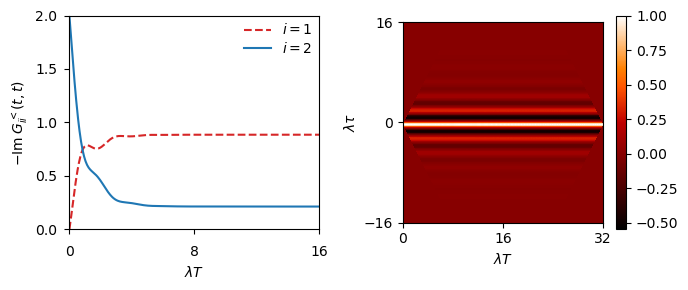

In [10]:
let
    function meshgrid(xin, yin)
      nx=length(xin)
      ny=length(yin)
      xout=zeros(ny, nx)
      yout=zeros(ny, nx)
      for jx=1:nx
          for ix=1:ny
              xout[ix, jx]=xin[jx]
              yout[ix, jx]=yin[ix]
          end
      end
      return (x=xout, y=yout)
    end

    steps = 1
    cmap = "gist_heat";

    Y, X = meshgrid(sol.t[1:steps:end], sol.t[1:steps:end]);

    xpad = 8
    ypad = 5

    fig = figure(figsize=(7, 3))

    ax = subplot(121)

    plot(sol.t, [-imag(GL.data[1, 1, k, k]) for k in 1:length(sol.t)], ls="--", c="C3", label=L"i=1", lw=1.5)
    plot(sol.t, [-imag(GL.data[2, 2, k, k]) for k in 1:length(sol.t)], ls="-", c="C0", label=L"i=2", lw=1.5)

    T = sol.t[end]

    ax.set_xlim(0, T/2)
    ax.set_xticks([0, T/4, T/2])
    ax.set_ylim(0, 2.0)
    ax.set_xlabel(L"\lambda T")
    ax.set_ylabel(L"-\mathrm{Im}\; G^<_{ii}(t, t)")
    ax.xaxis.set_tick_params(pad=xpad)
    ax.yaxis.set_tick_params(pad=ypad)
    ax.legend(loc="best", handlelength=1.9, frameon=false, borderpad=0, labelspacing=0.25)

    ax = subplot(122)
    X, Y = meshgrid(ts[1:steps:end], taus[1:steps:end]);
    vmin = 1.0
    vmax = -0.5

    heatmap = ax.pcolormesh(X, Y, -ρ_11_wigner[1:steps:end, 1:steps:end] |> imag, cmap=cmap, vmin=vmin, vmax=vmax, rasterized=true)
    heatmap.set_edgecolor("face")

    ax.set_xlabel(L"\lambda T")
    ax.set_ylabel(L"\lambda \tau")
    ax.set_xlim(0, T)
    ax.set_xticks([0, T/2, T])
    ax.set_ylim(-T/2, T/2)
    ax.set_yticks([-T/2, 0, T/2])
    colorbar(mappable=heatmap)
    ax.set_aspect("equal")

    tight_layout()
    # savefig("boson_example_1.pdf")
    fig
end;

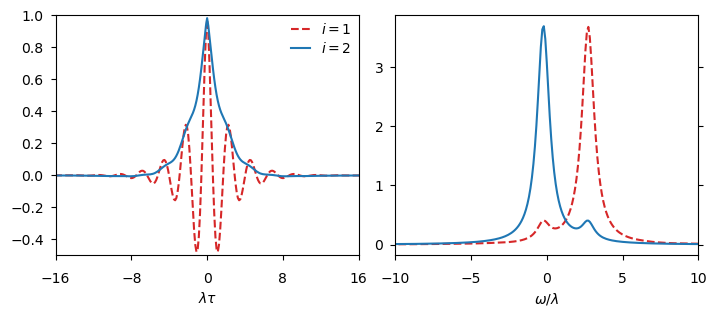

In [11]:
let
    xpad = 8
    ypad = 5

    T = sol.t[end]

    fig = figure(figsize=(7, 3))

    ax = subplot(121)
    plot(taus, -ρ_11_wigner[:, Int(floor(length(taus)/2))] |> imag, ls="--", c="C3", label=L"i=1", lw=1.5) # fixed T
    plot(taus, -ρ_22_wigner[:, Int(floor(length(taus)/2))] |> imag, ls="-", c="C0", label=L"i=2", lw=1.5)
    ax.set_xlabel(L"\lambda \tau")
    ax.set_xlim(-T/2, T/2)
    ax.set_ylim(-0.5, 1.0)
    ax.set_xticks([-T/2, -T/4, 0, T/4, T/2])
    ax.xaxis.set_tick_params(pad=xpad)
    ax.yaxis.set_tick_params(pad=ypad)
#     ax.set_ylabel(L"-\textrm{Im}\, A_{ii}(T, \tau)_W")
    ax.legend(loc="best", handlelength=1.4, frameon=false, borderpad=0, labelspacing=0.25)

    ax = subplot(122)
    plot(ωs, -ρ_11_FFT[:, Int(floor(length(taus)/2))] |> imag, ls="--", c="C3", lw=1.5)
    plot(ωs, -ρ_22_FFT[:, Int(floor(length(taus)/2))] |> imag, ls="-", c="C0", lw=1.5)
    ax.set_xlabel(L"\omega/\lambda")
    ax.set_xlim(10 .* (-1, 1))
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.xaxis.set_tick_params(pad=xpad)
    ax.yaxis.set_tick_params(pad=ypad)
#     ax.set_ylabel(L"-\textrm{Im}\, A_{ii}(T, \omega)_{\tilde{W}}", labelpad=16)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("both")

    tight_layout(pad=0.1, w_pad=0.5, h_pad=0)
    # savefig("boson_example_2.pdf")
    fig
end;